# 3.2 GatedMLP eigenvector analysis

In [1]:
# Now you can import modules from this directory
import torch
import os
from src.plotter import EigenvectorPlotter
from src.heist import load_model
import imageio
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from src.helpers import action_space, evaluate_model
from collections import Counter
import random
from procgen import ProcgenEnv
from src.vec_env import VecExtractDictObs, VecMonitor, VecNormalize
from src.bilinear_impala_simplified import BimpalaCNN, TopKBimpalaCNN
import matplotlib.pyplot as plt
from src.heist import create_venv as create_venv_simple
import einops
from src.utils import *
from src.helpers import ModelActivations, get_model_layer_names
import multiprocessing
from multiprocessing import Pool, set_start_method
from tqdm import tqdm
from functools import partial
import pickle
import src.ppo

In [2]:

model_path = "/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/bilinear_models/bimpala_heist_simplified.pt"
# model_path = "/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/bilinear_models/bimpala_maze_simplified.pt"
model =load_model(model_path,7)
print(model)
for k in model.state_dict():
    print(k)
state_dict = model.state_dict()

/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/src/heist.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model

Model loaded from /mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/bilinear_models/bimpala_heist_simplified.pt
BimpalaCNN(
  (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv_seqs): ModuleList(
    (0-2): 3 x ConvSequence(
      (max_pool2d): MaxPool2d(kernel_size=7, stride=2, padding=3, dilation=1, ceil_mode=False)
      (res_block0): ResidualBlock(
        (conv0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (conv1): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      )
      (res_block1): ResidualBlock(
        (conv0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (conv1): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      )
    )
  )
  (hidden_fc1): Linear(in_features=2048, out_features=256, bias=False)
  (hidden_fc2): Linear(in_features=2048, out_features=256, bias=False)
 

In [3]:
from src.ppo import Config, PPO, create_venv,create_gif
env_config = Config()
device = torch.device(f'cuda:{env_config.gpu}' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
agent = PPO(model.to(device),device)


Using device: cuda:0


In [4]:
def simulate_episodes(agent, env, num_episodes, save_gifs=False):
    action_counts = np.zeros(env.action_space.n, dtype=int)  # Assuming discrete action space

    for episode in range(num_episodes):
        obs = env.reset()
        frames = []
        actions = []
        done = False
        
        while not done:
            action = agent.batch_act(obs)
            obs, _, dones, infos = env.step(action)

            # Collect actions and frames
            actions.append(action[0])  # Assuming action is returned as a numpy array
            frame = env.render(mode='rgb_array')
            frames.append(frame)

            done = dones.any()

        # Update action counts
        unique, counts = np.unique(actions, return_counts=True)
        action_counts[unique] += counts

        # Optionally save the episode as a GIF
        if save_gifs:
            gif_filename = f'episode_{episode + 1}.gif'
            create_gif(frames, gif_filename)
    
    return action_counts
def plot_action_frequencies(action_counts):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(action_counts)), action_counts, color='blue')
    plt.xlabel('Action')
    plt.ylabel('Frequency')
    plt.title('Action Frequencies Across Episodes')
    plt.show()

In [5]:
def visualize_action_effect(frames):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i, ax in enumerate(axes.flat):
        if i < len(frames):
            frame = frames[i]
            if isinstance(frame, np.ndarray):
                if frame.ndim == 4:
                    frame = frame.squeeze(0)
                if frame.shape[0] == 3:
                    frame = np.transpose(frame, (1, 2, 0))
                if frame.dtype in ['float32', 'float64'] and frame.max() > 1.0:
                    frame = frame / 255.0
            elif isinstance(frame, torch.Tensor):
                frame = frame.cpu().numpy()
                if frame.ndim == 4:
                    frame = frame.squeeze(0)
                if frame.shape[0] == 3:
                    frame = np.transpose(frame, (1, 2, 0))
                if frame.dtype in ['float32', 'float64'] and frame.max() > 1.0:
                    frame = frame / 255.0
            ax.imshow(frame)
            ax.set_title(f"Step {i}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

def take_action_repeatedly(env, action, steps=10):
    obs = env.reset()
    frames = [obs]
    for _ in range(steps):
        obs, reward, done, info = env.step(np.array([action]))
        frames.append(obs)
        if np.all(done):
            break
    return frames

def investigate_actions():
    for action in [0,1,2,3,5,6,7,8]:
        venv = create_venv_simple(num_envs=1, start_level=random.randint(0, 1000000000), num_levels=0)
        print(f"Testing action {action}")
        frames = take_action_repeatedly(venv, action)
        visualize_action_effect(frames)
      

#investigate_actions()

In [5]:
env = create_venv(env_config)
num_episodes = 20 # Define how many episodes you want to simulate
action_counts = simulate_episodes(agent, env, num_episodes, save_gifs=True)
plot_action_frequencies(action_counts)

NameError: name 'simulate_episodes' is not defined

# Decomposing hiddenfc expanded across each action of the player


In [6]:
print(list(state_dict.keys()))
W = state_dict["hidden_fc1.weight"].to("cpu").detach()
V = state_dict["hidden_fc2.weight"].to("cpu").detach()
W_out = state_dict["logits_fc.weight"].to("cpu").detach()
print(W.shape)
B = get_B_tensor(W, V)
B = einops.rearrange(B, "out (in1 in2) -> out in1 in2", in1 = 2048)

B_proj = einops.einsum(W_out, B, "class h2, h2 in1 in2-> class in1 in2")
B_proj1 = 0.5 * B_proj + 0.5 * B_proj.transpose(-2,-1)
eigvals, eigvecs = torch.linalg.eigh(B_proj1)
print(eigvals.shape,eigvecs.shape)

['conv.weight', 'conv.bias', 'conv_seqs.0.res_block0.conv0.weight', 'conv_seqs.0.res_block0.conv1.weight', 'conv_seqs.0.res_block1.conv0.weight', 'conv_seqs.0.res_block1.conv1.weight', 'conv_seqs.1.res_block0.conv0.weight', 'conv_seqs.1.res_block0.conv1.weight', 'conv_seqs.1.res_block1.conv0.weight', 'conv_seqs.1.res_block1.conv1.weight', 'conv_seqs.2.res_block0.conv0.weight', 'conv_seqs.2.res_block0.conv1.weight', 'conv_seqs.2.res_block1.conv0.weight', 'conv_seqs.2.res_block1.conv1.weight', 'hidden_fc1.weight', 'hidden_fc2.weight', 'logits_fc.weight', 'logits_fc.bias', 'value_fc.weight', 'value_fc.bias']
torch.Size([256, 2048])


/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/.venv/lib/python3.10/site-packages/einops/parsing.py:137: RuntimeWarning: It is discouraged to use axes names that are keywords: class
  warnings.warn("It is discouraged to use axes names that are keywords: {}".format(name), RuntimeWarning)


torch.Size([15, 2048]) torch.Size([15, 2048, 2048])


torch.Size([15, 2048, 2048])


58

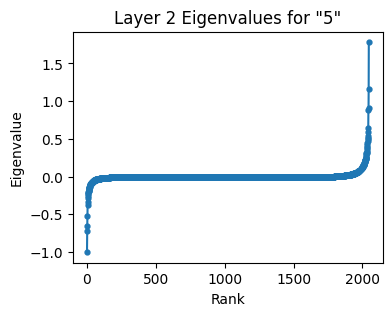

In [6]:
class_indices = [0,1,2,3,5,6,7,8]
#Moving up
class_idx = 5
Q = B_proj1[class_idx]
print(B_proj.shape)
eigvals1, eigvecs1 = torch.linalg.eigh(Q)

plt.figure(figsize=(4,3))
plt.plot(eigvals1,'.-', markersize=7)
plt.ylabel('Eigenvalue')
plt.xlabel('Rank')
plt.title(f'Layer 2 Eigenvalues for "{class_idx}"')
len([eigenval for eigenval in eigvals1 if eigenval >0.1])

In [6]:
def process_and_plot_topk_eigenvectors(eigvals, eigvecs, topk, plot=True):
    # Reshape eigenvectors from flat vector to image dimensions
    reshaped_eigvecs = eigvecs.view(-1, 32, 8, 8)

    # Extract positive and negative eigenvalues separately
    positive_indices = eigvals > 0
    negative_indices = eigvals < 0

    # Sort positive and negative eigenvalues separately
    pos_sorted_indices = torch.argsort(eigvals[positive_indices], descending=True)
    neg_sorted_indices = torch.argsort(eigvals[negative_indices])  # Sorting in ascending to find most negative

    # Adjust topk based on the number of available positive/negative eigenvalues
    top_pos_indices = pos_sorted_indices[:min(topk, len(pos_sorted_indices))]
    top_neg_indices = neg_sorted_indices[:min(topk, len(neg_sorted_indices))]

    # Re-index to original eigenvector indices
    top_pos_indices = torch.nonzero(positive_indices)[top_pos_indices].squeeze()
    top_neg_indices = torch.nonzero(negative_indices)[top_neg_indices].squeeze()

    # Function to plot eigenvectors
    def plot_eigenvectors(eigenvectors, eigenvalues, title_prefix):
        for i in range(len(eigenvectors)):
            fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))  # Create subplots for up to 32 channels
            title = f"{title_prefix} Eigenvector {i+1}, Eigenvalue: {eigenvalues[i]:.4f}"
            fig.suptitle(title)
            axes = axes.flatten()
            for j, ax in enumerate(axes):
                if j < eigenvectors[i].shape[0]:  # Check if the channel exists
                    ax.imshow(eigenvectors[i][j], cmap='gray')
                    ax.axis('off')
                else:
                    ax.axis('off')  # Turn off axis for unused subplots
            plt.show()
    if plot:
        # Plot top positive eigenvectors
        if len(top_pos_indices) > 0:
            plot_eigenvectors(reshaped_eigvecs[top_pos_indices], eigvals[top_pos_indices], "Top Positive")
        else:
            print("No positive eigenvalues found within the top k range.")

        # Plot top negative eigenvectors
        if len(top_neg_indices) > 0:
            plot_eigenvectors(reshaped_eigvecs[top_neg_indices], eigvals[top_neg_indices], "Top Negative")
        else:
            print("No negative eigenvalues found within the top k range.")

    return reshaped_eigvecs[top_pos_indices], eigvals[top_pos_indices], reshaped_eigvecs[top_neg_indices], eigvals[top_neg_indices]



In [7]:
from src.ppo import rollout_episode_obs
def create_dataset_one_episode(model, device, num_levels= 0, progress= 20, env_name = "maze"):
    
    env = create_venv_simple(num_envs=1, start_level=random.randint(0, 1000000000), num_levels=num_levels, env_name=env_name)
    agent = PPO(model, device)
    envs = rollout_episode_obs(agent, env, progress= progress)
    return envs
def create_dataset_multiple_episodes(model, device, num_levels= 0):   
    env = create_venv_simple(num_envs=1, start_level=random.randint(0, 1000000000), num_levels=num_levels, env_name="maze")
    return [env.reset()]

def get_activations(modelactivations: ModelActivations,observation, layers, device):
    observation = torch.tensor(observation, device=device, dtype=torch.float32)
    _, activations = modelactivations.run_with_cache(observation, layers)
    return activations

def get_activations_for_dataset(modelactivations, dataset, layers, device):
    dataset_with_activations = []
    # Use tqdm to show a progress bar over the dataset iteration
    for observation in tqdm(dataset, desc="Computing activations"):
        # Convert the observation to a tensor
        observation_tensor = torch.tensor(observation, device=device, dtype=torch.float32)
        # Compute activations
        _, activation = modelactivations.run_with_cache(observation_tensor, layers)
        # Append both observation and its activations to the new dataset list
        dataset_with_activations.append((observation_tensor, activation[layers[0].replace('.', '_')][0]))
    return dataset_with_activations

def find_top_observations_by_eigenvector(dataset,eigenvalues, eigenvectors, topk=15, topk_images = 50):


    # Initialize tensors to store the top-k eigenvalues and eigenvectors for each class
    sorted_indices = torch.argsort(torch.abs(eigenvalues), descending=True)
    topk_indices = sorted_indices[:topk]
    top_k_eigenvalues = eigenvalues[topk_indices]
    top_k_eigenvectors = eigenvectors[:, topk_indices]
    
    results = {i: {'top_observations': [], 'max_score': float('-inf')} for i in range(top_k_eigenvectors.size(-1))}

    # Wrap the outer loop with tqdm for a progress bar
    for observation, activation in tqdm(dataset, desc="Processing Observations"):
        
        activation_flat = activation.reshape(1, -1).to(device)
        #print("shape of activation and eigenvectors", activation_flat.squeeze(0).shape,top_k_eigenvectors.shape, top_k_eigenvalues.shape )
        # Compute dot product for each eigenvector
        dot_products = torch.einsum('a, a t -> t', activation_flat.squeeze(0), top_k_eigenvectors.to(activation_flat.device))
        sims = top_k_eigenvalues.to(activation_flat.device) * dot_products**2
        #print("shape of sims", sims.shape)
   
        # Update results for each eigenvector
        for i, value in enumerate(sims):
            score= torch.abs(value)
            if score > results[i]['max_score']:
                results[i]['max_score'] = value.item()
            results[i]['top_observations'].append((observation, value.item()))

    # Sort and limit to top k observations for each eigenvector after all are processed
    for i in results:
        results[i]['top_observations'] = list(results[i]['top_observations'])
        results[i]['top_observations'].sort(key=lambda x: abs(x[1]), reverse=True)
        results[i]['top_observations'] = results[i]['top_observations'][:topk_images]

    return results, top_k_eigenvalues 
def generate_dataset(directory, progress=20, env_name = "maze"):
    os.makedirs(directory, exist_ok = True)
    for j in range(5):
        dataset = []
        # Wrap the inner loop with tqdm for progress tracking
        for i in tqdm(range(2000), desc=f'Generating Dataset for Batch {j}'):
            dataset.extend(create_dataset_one_episode(model, device, progress=progress, env_name = env_name))
        output_path = os.path.join(directory, f'{env_name}_dataset_progress_{progress}_batch{j}.pickle')
        # Save the dataset to a pickle file
        with open(output_path, 'wb') as file:
            pickle.dump(list(dataset), file)
def load_and_combine_datasets(num_files, dataset_folder="", progress= 20, env_name = "maze"):
    # List to hold all observations from all datasets
    all_observations = []
    
    # Generate file names based on known naming pattern
    dataset_files = [f'datasets/{env_name}_dataset_progress_{progress}_batch{i}.pickle' for i in range(num_files)]

    # Loop through each file, load it, and extend the master list
    for dataset_file in dataset_files:
        file_path = os.path.join(dataset_folder, dataset_file)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            all_observations.extend(data)
    
    return all_observations

In [8]:
#generate_dataset(directory="datasets", env_name= 'heist')
dataset = load_and_combine_datasets(5, env_name= 'heist')
modelactivations = ModelActivations(model)
print(get_model_layer_names(model))
enhanced_dataset = get_activations_for_dataset(modelactivations, dataset,['conv_seqs.2.res_block1.conv1'],device)

print(len(enhanced_dataset))

['conv', 'conv_seqs', 'conv_seqs.0', 'conv_seqs.0.max_pool2d', 'conv_seqs.0.res_block0', 'conv_seqs.0.res_block0.conv0', 'conv_seqs.0.res_block0.conv1', 'conv_seqs.0.res_block1', 'conv_seqs.0.res_block1.conv0', 'conv_seqs.0.res_block1.conv1', 'conv_seqs.1', 'conv_seqs.1.max_pool2d', 'conv_seqs.1.res_block0', 'conv_seqs.1.res_block0.conv0', 'conv_seqs.1.res_block0.conv1', 'conv_seqs.1.res_block1', 'conv_seqs.1.res_block1.conv0', 'conv_seqs.1.res_block1.conv1', 'conv_seqs.2', 'conv_seqs.2.max_pool2d', 'conv_seqs.2.res_block0', 'conv_seqs.2.res_block0.conv0', 'conv_seqs.2.res_block0.conv1', 'conv_seqs.2.res_block1', 'conv_seqs.2.res_block1.conv0', 'conv_seqs.2.res_block1.conv1', 'hidden_fc1', 'hidden_fc2', 'logits_fc', 'value_fc']


Computing activations:  19%|█▊        | 93465/504366 [02:36<11:28, 596.79it/s]


KeyboardInterrupt: 

In [9]:
import os
import matplotlib.pyplot as plt

def save_fig_with_text_and_images(top_obs_dict, eigval,action_number, filename, directory):
    # Create the directory if it does not exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    keys = list(top_obs_dict.keys())
    for i in keys:
        data = top_obs_dict[i]
        observations = data['top_observations']
        num_images = len(observations)
        print("number of images", num_images)

        # Create a figure with subplots - adjust figsize as needed
        fig, axs = plt.subplots(1, num_images, figsize=(num_images * 5, 5))
        fig.suptitle(f"Action Number: {action_number}, Eigenvector Index: {i}, Eigvalue: {eigval[i]}, Max Similarity: {data['max_score']:.2f}")

        if num_images == 1:  # If there's only one image, make sure axs is iterable
            axs = [axs]

        for ax, (observation, sim) in zip(axs, observations):
            if observation.dim() == 4:
                observation = observation.squeeze(0)
            if observation.shape[0] == 3:
                observation = observation.permute(1, 2, 0)
            observation = observation.cpu().numpy()
            if observation.dtype in ['float32', 'float64'] and observation.max() > 1.0:
                observation /= 255.0

            # Setting title with similarity score
            ax.imshow(observation)
            ax.axis('off')
            ax.set_title(f"Sim Score: {sim:.2f}")

        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # Define the complete path where the figure will be saved
        full_path = os.path.join(directory, f'{filename}_eigvec_{i}_action_{action_number}.png')
        # Save the figure with a unique name for each eigenvector index
        plt.savefig(full_path)
        plt.close()


In [16]:
# Usage example:
W = state_dict["hidden_fc1.weight"].to("cpu").detach()
V = state_dict["hidden_fc2.weight"].to("cpu").detach()
W_out = state_dict["logits_fc.weight"].to("cpu").detach()
B = get_B_tensor(W, V)
B = einops.rearrange(B, "out (in1 in2) -> out in1 in2", in1 = 2048)

B_proj = einops.einsum(W_out, B, "class h2, h2 in1 in2-> class in1 in2")
B_proj1 = 0.5 * B_proj + 0.5 * B_proj.transpose(-2,-1)

actions = {
    'LEFT': [0, 1, 2],
    'DOWN': [3],
    'UP': [5],
    'RIGHT': [6, 7, 8],
    'NOOP': [4,9,10,11,12,13,14],
}
for action in actions:
    action_indices = actions[action]
    Q = sum([B_proj1[action_indices[i]] for i in range(len(action_indices))])
    
    eigvals, eigvecs = torch.linalg.eigh(Q)
    print(eigvals.shape, eigvecs.shape)
    top_obs_dict, topk_eigvals= find_top_observations_by_eigenvector(enhanced_dataset, eigvals, eigvecs, topk= 2, topk_images = 50)
    save_fig_with_text_and_images(top_obs_dict,topk_eigvals, action,filename ="", directory= f"results/{actions[action]}")

torch.Size([2048]) torch.Size([2048, 2048])


Processing Observations:   4%|▍         | 958/24509 [00:08<03:29, 112.47it/s]


KeyboardInterrupt: 

# Let's keep the topk eigenvectors of the model and ablate the remaining eigenvectors

In [10]:
from src.heist import create_venv as create_env
# Usage example:
W = state_dict["hidden_fc1.weight"].to("cpu").detach()
V = state_dict["hidden_fc2.weight"].to("cpu").detach()
W_out = state_dict["logits_fc.weight"].to("cpu").detach()
B = get_B_tensor(W, V)
B = einops.rearrange(B, "out (in1 in2) -> out in1 in2", in1 = 2048)

B_proj = einops.einsum(W_out, B, "class h2, h2 in1 in2-> class in1 in2")
B_proj1 = 0.5 * B_proj + 0.5 * B_proj.transpose(-2,-1)

def initialize_models(obs_space, num_outputs, kernel_size,topk,B, replacement_layers =["mlp"]):
    original_model = BimpalaCNN(obs_space, num_outputs, kernel_size)
    model_path = "/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/bilinear_models/bimpala_maze_simplified.pt"
    original_model = load_model(model_path,7)
    # Create the modified model
    modified_model = TopKBimpalaCNN(obs_space, num_outputs, kernel_size=kernel_size, topk= topk, B=B, replacement_layers=replacement_layers)
    
    modified_model.transfer_params_from(original_model)
    
    return original_model, modified_model

/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/.venv/lib/python3.10/site-packages/einops/parsing.py:137: RuntimeWarning: It is discouraged to use axes names that are keywords: class
  warnings.warn("It is discouraged to use axes names that are keywords: {}".format(name), RuntimeWarning)


In [17]:
from collections import defaultdict
from src.ppo import rollout_episode,create_gif,PPO
def evaluate_model_multi_env(model, create_env, num_episodes=100, render_every=None,gif= None, device = torch.device(f'cuda:3' if torch.cuda.is_available() else 'cpu'),env_name = "maze"):
    """
    Evaluate a trained PPO model over multiple episodes across multiple environments.
    
    Args:
    - agent: The trained PPO agent
    - env_creator: A function that creates and returns an environment
    - env_configs: A list of dictionaries, each containing configuration for an environment
    - num_episodes: Number of episodes to run for evaluation per environment
    - render_every: If not None, render every nth episode
    
    Returns:
    - A dictionary containing evaluation metrics for each environment and overall
    """

    overall_results = defaultdict(list)

    agent = PPO(model=model, device=device)
    

    total_rewards = [None] * num_episodes
    success_count = 0
    success_info = [None] * num_episodes

    for episode in range(num_episodes):
        env = create_env(env_name= env_name)
        env.reset()
        frames, reward, info = rollout_episode(agent,env, return_info=True)
        total_rewards[episode] = reward
        if reward >0:
            success_count += 1
        success_info[episode] = info['r']

        if gif:
            create_gif(frames, f"{gif}_{episode}.gif")
          
    percentage_success = success_count/num_episodes
    percentage_info_success = sum(success_info)/num_episodes
    env_results = {
        "mean_reward": np.mean(success_info),
        "std_reward": np.std(success_info),
        "min_reward": np.min(total_rewards),
        "max_reward": np.max(total_rewards),
        "percentage_success": percentage_success,
        #"percentage_info_success": percentage_info_success

    }

    return env_results


In [12]:
def plot_topk_results(results_list):
    topk_values = [res['topk'] if res['topk'] != 0 else 0.1 for res in results_list]
    original_topk_labels = [res['topk'] for res in results_list]

    mean_rewards = [res['mean_reward'] for res in results_list]
    std_rewards = [res['std_reward'] for res in results_list]
    success_rates = [res['percentage_success'] for res in results_list]

    # Create a new figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot mean_reward with error bars on the first y-axis
    ax1.set_xlabel('Top-k Model')
    ax1.set_ylabel('Mean Reward', color='tab:blue')
    ax1.errorbar(topk_values, mean_rewards, yerr=std_rewards, fmt='o-', color='tab:blue', 
                 label='Mean Reward', capsize=5, capthick=2, ecolor='lightblue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xscale('log')

    # Create a second y-axis for success_rate
    ax2 = ax1.twinx()
    ax2.set_ylabel('Success Rate (%) out of 100 trials', color='tab:green')
    ax2.plot(topk_values, success_rates, color='tab:green', marker='x', label='Success Rate')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Custom tick labels for top-k, to display '0' instead of 0.1
    ax1.set_xticks(topk_values)
    ax1.set_xticklabels([str(x) if x != 0.1 else '0' for x in original_topk_labels])

    # Add titles and labels
    plt.title('Mean Reward (with Std Dev) and Success Rate Over Different Top-k Values')

    # Show legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()

    # Display the plot
    plt.show()

In [18]:
#for computing B_sym
def compute_B_sym(W, V):
    """
    Compute the exact tensor decomposition for bilinear convolutional tensors.
    
    Args:
    W, V: Tensors of shape (c_out, c_in, k, k)
    
    Returns:
    B: Tensor of shape (c_out, c_in*k*k, c_in*k*k)
    """
    c_out, c_in, k, _ = W.shape
    B = torch.zeros(c_out, c_in*k*k, c_in*k*k, device=W.device, dtype=W.dtype)
    
    for l in range(c_out):
        W_outl = W[l]  # c_in by k by k
        V_outl = V[l]  # c_in by k by k
        for i in range(c_in):
            for j in range(c_in):
                W_i = W_outl[i]  # k x k
                V_j = V_outl[j]  # k x k
                W_i_f = W_i.reshape(-1)  # k*k
                V_j_f = V_j.reshape(-1)  # k*k
                block = torch.outer(W_i_f, V_j_f)  # k*k x k*k
                B[l, i*k*k:(i+1)*k*k, j*k*k:(j+1)*k*k] = block
    #Symmetrysing B            
    B_sym = torch.zeros_like(B)
    for o in range(c_out):
        B_sym[o] = 0.5 * (B[o] + B[o].T) 
    return B_sym

In [13]:
W = state_dict['conv_seqs.2.res_block1.conv0.weight']
V = state_dict['conv_seqs.2.res_block1.conv1.weight']

#the biggest topk size is 32 * 7 * 7 = 1568, number of iterations to reach 0 is 13
# Create the 3D block matrix
B_sym = compute_B_sym(W, V)

topk = 0
#results = [None] * 13
#for i in range(13):
    env = create_env()
    usual_model, modified_model = initialize_models(env.observation_space, env.action_space.n, kernel_size = 7, topk=topk, B=B_sym, replacement_layers=["conv_seq_2"])
    results[i] = evaluate_model_multi_env(model = modified_model, create_env = create_venv_simple, num_episodes=1)
    results[i]['topk'] = topk
    #topk = topk//2 

/mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/src/heist.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model

Model loaded from /mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/bilinear_models/bimpala_maze_simplified.pt
Parameters transferred and modified successfully
the shape of the convolutional outputs: top k values , shape of convolutions 4 torch.Size([32, 8, 8]) tensor([[[-1.7070e-02, -1.0671e-02, -2.7605e-02,  ..., -3.3533e-03,
          -9.4315e-03, -2.6066e-03],
         [-1.9542e-03,  4.7110e-03,  2.0476e-02,  ...,  9.2147e-04,
          -5.3797e-04, -2.4190e-04],
         [ 4.8853e-03,  2.1924e-02,  4.4166e-02,  ...,  8.2701e-03,
          -1.1947e-02, -1.5554e-02],
         ...,
         [ 1.9906e-02,  5.8875e-02,  8.4712e-02,  ..., -1.9921e-02,
          -8.8743e-03, -1.4038e-04],
         [ 2.3950e-02,  8.1203e-02,  1.2266e-01,  ..., -7.1388e-03,
          -6.2677e-03, -5.7989e-04],
         [ 3.3380e-02,  7.9489e-02,  1.1656e-01,  ..., -6.2882e-03,
          -2.0696e-02, -1.2967e-03]],

        [[-1.0299e-02, -1.6899e-02,  2.7040e-03,  ..., -1.125

In [23]:
W = state_dict['conv_seqs.2.res_block1.conv0.weight']
V = state_dict['conv_seqs.2.res_block1.conv1.weight']

#the biggest topk size is 32 * 7 * 7 = 1568, number of iterations to reach 0 is 13
# Create the 3D block matrix
B_sym = compute_B_sym(W, V)

topk = 1568
env = create_env(env_name="heist")
usual_model, modified_model = initialize_models(env.observation_space, env.action_space.n, kernel_size = 7, topk=topk, B=B_sym, replacement_layers=["conv_seq_2"])
results = evaluate_model_multi_env(model = modified_model, create_env = create_venv_simple, num_episodes=2, gif="heist_gift_nothing_ablated_conv", env_name="heist")


Model loaded from /mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/bilinear_models/bimpala_maze_simplified.pt
Parameters transferred and modified successfully
the shape of the convolutional outputs: top k values , shape of convolutions 1568 torch.Size([32, 8, 8]) tensor([[[-4.8491e-02,  1.1844e+00,  3.6706e+00,  ...,  1.5139e+00,
          -3.9613e-02,  1.3021e+00],
         [ 3.6853e-01,  1.3459e+00,  1.3490e+00,  ..., -2.1224e+00,
          -1.7787e+00,  6.1095e-01],
         [ 9.5271e-01,  1.3371e+00,  9.2789e-01,  ..., -5.1757e+00,
          -7.1341e-01, -3.6852e-01],
         ...,
         [ 1.6500e+00,  3.0173e+00,  1.9550e+00,  ..., -3.3929e+00,
          -1.7520e-01,  1.8773e+00],
         [ 1.2727e+00,  3.8546e+00,  2.7407e+00,  ...,  8.7864e-03,
           7.2842e-01,  7.9862e-03],
         [ 7.9904e-01,  2.3444e+00,  2.6460e+00,  ...,  1.9716e-01,
           1.1012e+00,  2.9714e+00]],

        [[-2.7078e-01,  1.6831e+00, -2.3928e+00,  ...,  2.

KeyboardInterrupt: 

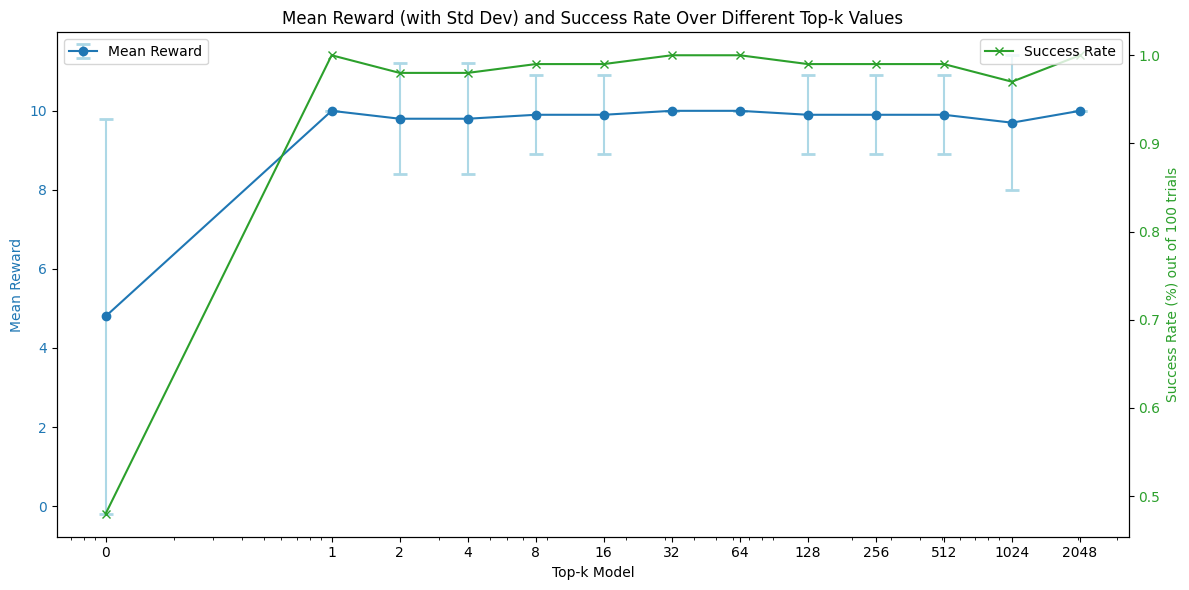

In [37]:
plot_topk_results(results)

In [16]:
#sanity check
env = create_env()
usual_model, modified_model = initialize_models(env.observation_space, env.action_space.n, kernel_size = 7, topk=1)
for i in range(10):
    evaluate_model_multi_env(model = modified_model, create_env = create_venv_simple,num_episodes=1, gif= f"top_1_model_{i}")

Model loaded from /mnt/ssd-1/mechinterp/narmeen/bilinear_experiments_official/bilinear_experiments/bilinear_models/bimpala_maze_simplified.pt
Parameters transferred and modified successfully
[{'prev_level_seed': 1145322527, 'prev_level_complete': 0, 'level_seed': 1145322527}]
[{'prev_level_seed': 1145322527, 'prev_level_complete': 0, 'level_seed': 1145322527}]
[{'prev_level_seed': 1145322527, 'prev_level_complete': 0, 'level_seed': 1145322527}]
[{'prev_level_seed': 1145322527, 'prev_level_complete': 0, 'level_seed': 1145322527}]
[{'prev_level_seed': 1145322527, 'prev_level_complete': 0, 'level_seed': 1145322527}]
[{'prev_level_seed': 1145322527, 'prev_level_complete': 0, 'level_seed': 1145322527}]
[{'prev_level_seed': 1145322527, 'prev_level_complete': 0, 'level_seed': 1145322527}]
[{'prev_level_seed': 1145322527, 'prev_level_complete': 0, 'level_seed': 1145322527}]
[{'prev_level_seed': 1145322527, 'prev_level_complete': 0, 'level_seed': 1145322527}]
[{'prev_level_seed': 1145322527, 'p